# LLM Training Data Augmentation - Classification of Kaggle Disaster Data

The goal of this notebook is to prepare the data for augmentation by an LLM and classification by two models:

1. Logistic regression
2. Single hidden-layer neural network

## Data

The data used in this project comes from the kaggle *Natural Language Processing with Disaster Tweets* competition at:  

https://www.kaggle.com/competitions/nlp-getting-started/data

This data consists of two files:
+ *train.csv* - 7485 labled tweets **after duplicate removals** 
+ *test.csv* - 3263 unlabled tweets

Because the *test.csv* labels are not available, the *train.csv* file was split into the following two files:

+ train_model.csv - data used to train model, 5988 labeled tweets
+ train_test.csv - held out and not used to train model, used as *pseudo-test* data, 1497 labeled tweets (~20% of the original training sample)

## Simplier NLP Classifier Models

Two types of models are created and compared:

1. Logistic Regression - This serves as the baseline
2. Single-Hidden layer neural network with 1000 nodes in the hidden layer

## LLM

ChatGPT 3.5 turbo will be used to augment the data used to train the models.

## Encodings

The Twitter GloVe embedding will be used to vectorize the input text.  These embeddings were downloaded from:

https://nlp.stanford.edu/data/glove.twitter.27B.zip


## Vectorize with all cleaned tweet tokens

Since the max number of tokens in the cleaned original training data is 29 and 26 for the cleaned augmented data, a 30 token input will be selected.  This will give us an input to the model that is 30 (tokens / tweet) x (50 dimensions / token) = 1500 dimensions / tweet.

Since all tweets will be less than 30 tokens, each input will be padded with the empty string token (<>).

## Build feature matrices

The following 4 feature matrices are built and exported so the can be read back in during modeling:

+ **feats_matrix_aug.txt** - 7485 rows where each row is a vectorized tweet padded to 30 tokens where each token is represented by a 50d GloVe twitter embedding and the empty string is used as the padding token.  1500 cols are the tweets padded to 30 tokens which are each converted to a 50d GloVe embedding
+ **feats_matrix_train_train.txt** - 80% of the original training data used to train each model, same vectorization as **feats_matrix_aug.txt**, xxxx rows, yyyy columns
+ **feats_matrix_train_test.txt** - 20% of the original training data used to test each model, same vectorization as **feats_matrix_aug.txt**, xxxx rows, yyyy columns
+ **feats_matrix_test.txt** - unlabeled test data provided by kaggle to test submissions, same vectorization as **feats_matrix_aug.txt**, xxxx rows, yyyy columns

The first 3 feature matrices have the following corresponding labels (`feats_matrix_test.txt` are unlabeled tweets):
+ labels_aug.txt
+ labels_train_train.txt
+ labels_train_test.txt

In [1]:
import projtools as pt
import numpy as np
import pandas as pd
%pwd

'D:\\llmamd'

In [2]:
# read in the feature matrices
feats_matrix_train_train = np.loadtxt('./data/feats_matrix_train_train.txt')
feats_matrix_train_test = np.loadtxt('./data/feats_matrix_train_test.txt')
feats_matrix_aug = np.loadtxt('./data/feats_matrix_aug.txt')
feats_matrix_test = np.loadtxt('./data/feats_matrix_test.txt')
# read in the labels
labels_train_train = np.loadtxt('./data/labels_train_train.txt', dtype='int')
labels_train_test = np.loadtxt('./data/labels_train_test.txt', dtype='int')
labels_aug = np.loadtxt('./data/labels_aug.txt', dtype='int')
print(f"shape of train train feature matrix: {feats_matrix_train_train.shape}, shape of train train labels: {labels_train_train.shape}")
print(f"dtype of train train labels: {labels_train_train.dtype}")
print(f"shape of train test feature matrix: {feats_matrix_train_test.shape}, shape of train test labels: {labels_train_test.shape}")
print(f"dtype of train test labels: {labels_train_test.dtype}")
print(f"shape of augmented feature matrix: {feats_matrix_aug.shape}, shape of augmented labels: {labels_aug.shape}")
print(f"dtype of augmented labels: {labels_aug.dtype}")
print(f"shape of (unlabeled) test feature matrix: {feats_matrix_test.shape}")

shape of train train feature matrix: (5988, 1500), shape of train train labels: (5988,)
dtype of train train labels: int32
shape of train test feature matrix: (1497, 1500), shape of train test labels: (1497,)
dtype of train test labels: int32
shape of augmented feature matrix: (7485, 1500), shape of augmented labels: (7485,)
dtype of augmented labels: int32
shape of (unlabeled) test feature matrix: (3263, 1500)


In [3]:
labels_train_train[:30]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1])

## Neural network models

### Activation function

Will experiment with sigmoid and ReLu.

### Hidden units

Will experiment with 100 and 300 nodes in the single hidden layer


## 10 Fold CV - ReLU vs. Sigmoid hidden layer activation function

In [4]:
import torch.nn as nn

# compare hidden layer activation functions
num_inputs = 1500
num_outputs = 1
hidden_units = [100, 300]  # number of units in to single hidden layer

i = 0  # evaluate activation function on the smaller hidden unit count to speed training
# use relu for hidden layer
model_h_relu = nn.Sequential(
    nn.Linear(num_inputs, hidden_units[i]),
    nn.ReLU(),
    nn.Linear(hidden_units[i], num_outputs),
    nn.Sigmoid()
)

# use sigmoid for hidden layer
model_h_sigmoid = nn.Sequential(
    nn.Linear(num_inputs, hidden_units[i]),
    nn.Sigmoid(),
    nn.Linear(hidden_units[i], num_outputs),
    nn.Sigmoid()
)

# both models have the same number of parameters
total_params = 0
for parameter in model_h_relu.parameters():
    total_params += parameter.numel()
print(f"both models have {hidden_units[i]} units in their hidden layers with {total_params} total parameters (weights and biases)")

both models have 100 units in their hidden layers with 150201 total parameters (weights and biases)


In [5]:
# compare these 2 models with 10-fold CV
import time
import torch
from sklearn.model_selection import StratifiedKFold, train_test_split

cv_folds = 10
t0 = time.time()  # init start time
print(f"starting {cv_folds}-fold CV at {time.ctime()}")

X = torch.tensor(feats_matrix_train_train, dtype=torch.float32)
y = torch.tensor(labels_train_train, dtype=torch.float32).reshape(-1, 1)  # make single col vector (N x 1)
print(f"feature tensor X has shape {X.shape}, labels tensor y has shape {y.shape}")

# train-test split: hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# define 10-fold cv test harness
kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True)

# evaluate model with ReLU hidden layer activation
cv_scores_relu = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = model_h_relu
    # train model, grab accuracy from the returned tuple
    acc, _ = pt.nn_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print(f"ReLU accuracy: {acc:.4f}")
    cv_scores_relu.append(acc)

starting 10-fold CV at Fri Apr 12 16:20:35 2024
feature tensor X has shape torch.Size([5988, 1500]), labels tensor y has shape torch.Size([5988, 1])
ReLU accuracy: 0.7786
ReLU accuracy: 0.7971
ReLU accuracy: 0.8186
ReLU accuracy: 0.8115
ReLU accuracy: 0.8568
ReLU accuracy: 0.8282
ReLU accuracy: 0.8162
ReLU accuracy: 0.8783
ReLU accuracy: 0.8616
ReLU accuracy: 0.9165


In [6]:
# evaluate model with sigmoid hidden layer activation
cv_scores_sigmoid = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = model_h_sigmoid
    # train model, grab accuracy from the returned tuple
    acc, _ = pt.nn_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print(f"sigmoid accuracy: {acc:.4f}")
    cv_scores_sigmoid.append(acc)

sigmoid accuracy: 0.7762
sigmoid accuracy: 0.8067
sigmoid accuracy: 0.7971
sigmoid accuracy: 0.7661
sigmoid accuracy: 0.8401
sigmoid accuracy: 0.8091
sigmoid accuracy: 0.8544
sigmoid accuracy: 0.8377
sigmoid accuracy: 0.8282
sigmoid accuracy: 0.8377


In [14]:
# compare model performance
relu_acc = np.mean(cv_scores_relu)
relu_std = np.std(cv_scores_relu)
sigmoid_acc = np.mean(cv_scores_sigmoid)
sigmoid_std = np.std(cv_scores_sigmoid)
print(f"ReLU accuracy: {relu_acc*100:.2f}%, std dev: {relu_std*100}%")
print(f"sigmoid accuracy: {sigmoid_acc*100:.2f}%, std dev: {sigmoid_std*100}%")

# print(f"finishing {cv_folds}-fold CV at {time.ctime()}")
t1 = time.time()  # finish cv time
exec_time = (t1 - t0) / 60.
# print(f"CV on two models took {exec_time:.2f} minutes to run")

ReLU accuracy: 83.63%, std dev: 3.9387710891492844%
sigmoid accuracy: 81.53%, std dev: 2.7761146455694306%


## 10 Fold CV - 100 vs. 300 nodes in hidden layer (ReLU activation function)

In [8]:
# setup the models to compare - 100 vs 300 hidden layer units w/ relu activation
i = 0  # 100
# smaller model
model_h_relu_100 = nn.Sequential(
    nn.Linear(num_inputs, hidden_units[i]),
    nn.ReLU(),
    nn.Linear(hidden_units[i], num_outputs),
    nn.Sigmoid()
)

i = 1  # 300
# larger model
model_h_relu_300 = nn.Sequential(
    nn.Linear(num_inputs, hidden_units[i]),
    nn.ReLU(),
    nn.Linear(hidden_units[i], num_outputs),
    nn.Sigmoid()
)

# models have differnt number of parameters
total_params_100h = 0
total_params_300h = 0
for params in model_h_relu_100.parameters():
    total_params_100h += params.numel()

for params in model_h_relu_300.parameters():
    total_params_300h += params.numel()

print(f"Model with {hidden_units[0]} units in the hidden layers has {total_params_100h} total parameters (weights and biases)")
print(f"Model with {hidden_units[1]} units in the hidden layers has {total_params_300h} total parameters (weights and biases)")

Model with 100 units in the hidden layers has 150201 total parameters (weights and biases)
Model with 300 units in the hidden layers has 450601 total parameters (weights and biases)


In [9]:
# reset start time for second round of CV
t0 = time.time()  # init start time
print(f"starting {cv_folds}-fold CV at {time.ctime()}")

X = torch.tensor(feats_matrix_train_train, dtype=torch.float32)
y = torch.tensor(labels_train_train, dtype=torch.float32).reshape(-1, 1)  # make single col vector (N x 1)
print(f"feature tensor X has shape {X.shape}, labels tensor y has shape {y.shape}")

# train-test split: hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# define 10-fold cv test harness
kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True)

# evaluate model with ReLU hidden layer activation
cv_scores_100_hidden = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = model_h_relu_100
    # train model, grab accuracy from the returned tuple
    acc, _ = pt.nn_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print(f"ReLU with 100 hidden units - accuracy: {acc:.4f}")
    cv_scores_100_hidden.append(acc)

starting 10-fold CV at Fri Apr 12 17:48:03 2024
feature tensor X has shape torch.Size([5988, 1500]), labels tensor y has shape torch.Size([5988, 1])
ReLU with 100 hidden units - accuracy: 0.7738
ReLU with 100 hidden units - accuracy: 0.8568
ReLU with 100 hidden units - accuracy: 0.8544
ReLU with 100 hidden units - accuracy: 0.8019
ReLU with 100 hidden units - accuracy: 0.9332
ReLU with 100 hidden units - accuracy: 0.9523
ReLU with 100 hidden units - accuracy: 0.9451
ReLU with 100 hidden units - accuracy: 0.9403
ReLU with 100 hidden units - accuracy: 0.9117
ReLU with 100 hidden units - accuracy: 0.9379


In [10]:
# evaluate model with sigmoid hidden layer activation
cv_scores_300_hidden = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = model_h_relu_300
    # train model, grab accuracy from the returned tuple
    acc, _ = pt.nn_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print(f"ReLU with 300 hidden units - accuracy: {acc:.4f}")
    cv_scores_300_hidden.append(acc)

ReLU with 300 hidden units - accuracy: 0.7952
ReLU with 300 hidden units - accuracy: 0.8807
ReLU with 300 hidden units - accuracy: 0.9236
ReLU with 300 hidden units - accuracy: 0.9045
ReLU with 300 hidden units - accuracy: 0.9021
ReLU with 300 hidden units - accuracy: 0.9141
ReLU with 300 hidden units - accuracy: 0.9451
ReLU with 300 hidden units - accuracy: 0.9093
ReLU with 300 hidden units - accuracy: 0.8950
ReLU with 300 hidden units - accuracy: 0.9021


In [13]:
# compare model performance
relu_100_hidden_acc = np.mean(cv_scores_100_hidden)
relu_100_hidden_std = np.std(cv_scores_100_hidden)
relu_300_hidden_acc = np.mean(cv_scores_300_hidden)
relu_300_hidden_std = np.std(cv_scores_300_hidden)
print(f"ReLU with 100 hidden units - overall accuracy: {relu_100_hidden_acc*100:.2f}%, std dev: {relu_100_hidden_std*100:.2f}%")
print(f"ReLU with 300 hidden units - overall accuracy: {relu_300_hidden_acc*100:.2f}%, std dev: {relu_300_hidden_std*100:.2f}%")

# print(f"finishing {cv_folds}-fold CV at {time.ctime()}")
t1 = time.time()  # finish cv time
exec_time = (t1 - t0) / 60.
# print(f"CV on two models took {exec_time:.2f} minutes to run")

ReLU with 100 hidden units - overall accuracy: 89.07%, std dev: 6.140374740036988%
ReLU with 300 hidden units - overall accuracy: 89.72%, std dev: 3.7685936014914407%


## Final neural net classifier

### Activation function

The first 10-fold CV pointed to using a **ReLU** for hidden layer activation function.  Not only did this function perform better in terms of accuracy, but it is more computationally efficient.  For both these reasons, **ReLU** was chosen as the hidden layer activation function.

### Number of hidden units

The second 10-fold CV results showed a slight improvement in accuracy using 300 instead of 100 hidden units.  This difference was only a little over a half of one percent which was much smaller than the standard deviations computed over each of the 10 folds.  Because the difference was relatively insignificant and the computational cost triples using 300 hidden units, **100** hidden units was selected for the number of units in the single hidden layer.

## Neural net classifiers

### Train on original data only

Use the `model_h_relu_100` model built in cell 4 above.

In [34]:
from datetime import datetime

# train the final model on the entire original training set
X = torch.tensor(feats_matrix_train_train, dtype=torch.float32)
y = torch.tensor(labels_train_train, dtype=torch.float32).reshape(-1, 1)  # make single col vector (N x 1)
# training and validation are the same in final training
acc, model_best_nn_orig = pt.nn_train(model_h_relu_100, X, y, X, y)  # train on original data only
time_stamp = datetime.now().strftime('%Y-%m-%d.%H.%M.%S')
file_name = './nn_models/' + time_stamp + 'model_best_nn_orig.pth'
print(f"saving trained model to: {file_name}")
torch.save(model_best_nn_orig.state_dict(), file_name)
# model_best_nn_orig = model_h_relu_100
# model_best_nn_orig.load_state_dict(torch.load(file_name))
# print(model_best_nn_orig)

saving trained model to: ./nn_models/2024-04-12.21.31.32model_best_nn_orig.pth


### Train on original + augmented data

In [35]:
# create train + aug feature and label inputs
train_train_aug_data = np.vstack((feats_matrix_train_train, feats_matrix_aug))
train_train_aug_labels = np.hstack((labels_train_train, np.array(labels_aug)))
print(feats_matrix_train_train.shape, feats_matrix_aug.shape,
      train_train_aug_data.shape, train_train_aug_labels.shape)

(5988, 1500) (7485, 1500) (13473, 1500) (13473,)


In [36]:
# train the final model on the entire original + augmented training set
X = torch.tensor(train_train_aug_data, dtype=torch.float32)
y = torch.tensor(train_train_aug_labels, dtype=torch.float32).reshape(-1, 1)  # make single col vector (N x 1)
# training and validation are the same in final training
acc, model_best_nn_orig_aug = pt.nn_train(model_h_relu_100, X, y, X, y)  # train on original + aug data
time_stamp = datetime.now().strftime('%Y-%m-%d.%H.%M.%S')
file_name = './nn_models/' + time_stamp + 'model_best_nn_orig_aug.pth'
print(f"saving trained model to: {file_name}")
torch.save(model_best_nn_orig_aug.state_dict(), file_name)
# model_best_nn_orig_aug = model_h_relu_100  # load an empty model for the weights to get loaded into
# model_best_nn_orig_aug.load_state_dict(torch.load(file_name))
# print(model_best_nn_orig_aug)

saving trained model to: ./nn_models/2024-04-12.21.39.20model_best_nn_orig_aug.pth


In [37]:
# both models tested on same labeled test data held out from training
X_test = torch.tensor(feats_matrix_train_test, dtype=torch.float32)
y_test = torch.tensor(labels_train_test, dtype=torch.float32).reshape(-1, 1)  # make single col vector (N x 1)

In [38]:
# evaluate the model trained on the original data using the labeled (train) test set
loaded_model.eval()
with torch.no_grad():
    y_mod_orig_probs = model_best_nn_orig(X_test)  # forward pass thru model trained on original data only
    y_mod_orig_aug_probs = model_best_nn_orig_aug(X_test)  # forward pass w/ same data, but model that was trained on original + aug

In [39]:
y_mods_both_probs = np.hstack((y_mod_orig_probs.numpy(), y_mod_orig_aug_probs.numpy()))  # horiz stack col's so we can plot together
print(y_mod_orig_probs.shape, y_mod_orig_aug_probs.shape, y_mods_both_probs.shape)

torch.Size([1497, 1]) torch.Size([1497, 1]) (1497, 2)


In [40]:
y_ground_truth = np.reshape(labels_train_test, (-1, 1))
# ground truth for each model (trained on orig data only and trained on orig + aug data)
# is the same, so columns for 1st and 2nd model are just horizontally stacked
y_ground_truth = np.hstack((y_ground_truth, y_ground_truth))
y_ground_truth.shape  # first 1497 rows are [0, 0], second 1497 rows are [1, 1]

(1497, 2)

Comparing 2 models
saving plot to Twitter_Disaster_Tweets_Classification_-_Neural_Networks.png
{'Trained on original': 0.7943122023660781, 'Trained on original + augmented': 0.7943122023660781}


<Figure size 640x480 with 0 Axes>

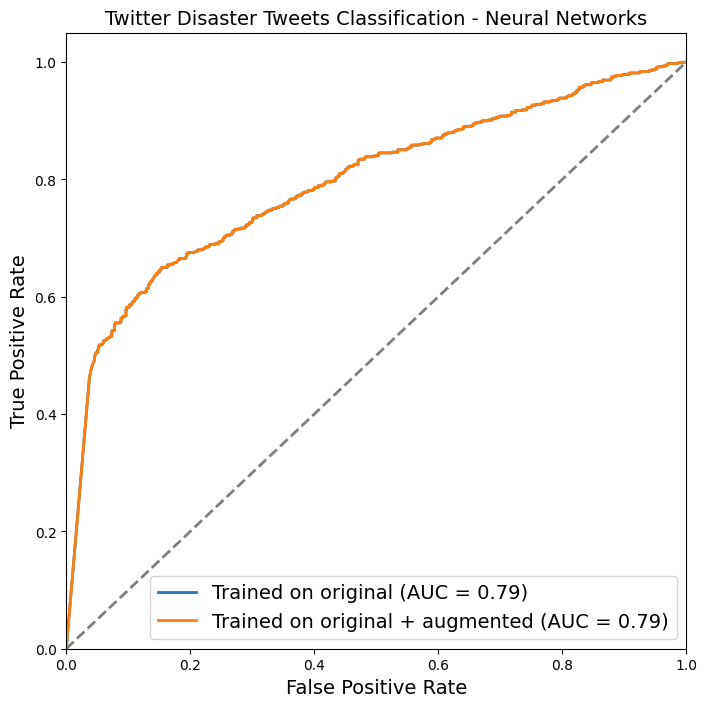

In [41]:
roc_neural, auc_neural = pt.get_roc_curves(y_ground_truth, y_mods_both_probs,
                                           model_names=['Trained on original', 'Trained on original + augmented'],
                                           plot_title='Twitter Disaster Tweets Classification - Neural Networks')
print(auc_neural)
roc_neural.show()